In [1]:
import mlrose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time


from mlrose_hiive import SARunner, GARunner, MIMICRunner, RHCRunner
from mlrose_hiive import ContinuousPeaksGenerator
%matplotlib inline

/Users/hongzheli/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
np.random.seed(123)
problem_name = 'CP'
# weights_dict = {}
# values_dict = {}
problem_sizes = [5, 10, 20, 25, 30, 40, 50]
# for problem_size in problem_sizes:
#     weights_dict[problem_size] = np.random.rand(problem_size)
#     values_dict[problem_size] = np.random.rand(problem_size)

columns = ['Algorithm', 'Fitness', 'Time', 'Iteration']
df_plot = pd.DataFrame(columns = columns)
# df_plot2 = pd.DataFrame(columns = ['Fitness', 'Param1', 'Algorithm'])
# df_plot3 = pd.DataFrame(columns = ['Fitness', 'Param2', 'Algorithm'])

### a classic NP-Hard optimization problem with no polynomial time solution. The strength of MIMIC was highlighted in this context, as it exploited the underlying structure of the problem space that was learned from previous iterations.

# Step 1. Pick a problem size, do hyperparameter tuning and find the best hyperparameters for all algorithms

In [3]:

problem_size = 20

# weight = weights_dict[problem_size]
# value = values_dict[problem_size]

problem = ContinuousPeaksGenerator().generate(seed=123, size=problem_size)

In [4]:
# Step 1 - define a problem size and tune hyperparameters


algorithm = 'RHC'
rhc = RHCRunner(problem=problem, 
                experiment_name='{}_{}'.format(problem_name, algorithm),
                output_directory=None, 
                iteration_list=2**np.arange(8),
                restart_list=list(range(1, 20)),
                seed=123)
df_run_stats, df_run_curves = rhc.run()

# fitness vs hyperparameter. 
df_p1 = df_run_curves.groupby('Restarts').max().reset_index()[['Fitness', 'Restarts']]
df_p1.columns = ['Fitness', 'Param1']
df_p1['Algorithm'] = algorithm
#df_p2 = df_run_curves.groupby('current_restart').max()['Fitness']

# find the best fitness
best_fitness = df_run_curves['Fitness'].max()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]

min_iter = best_runs['Iteration'].min()
best_curve_run = best_runs[best_runs['Iteration'] == min_iter]

min_eval = best_curve_run['FEvals'].min()
best_curve_run = best_curve_run[best_curve_run['FEvals'] == min_eval]
best_curve_run = best_curve_run.head(1)
best_curve_run


,Iteration,Time,Fitness,Restarts,max_iters,current_restart,FEvals
6814,22,0.023613,37.0,9,128,9,36


In [5]:
best_param = best_curve_run.iloc()[0]['current_restart']
# map back to the hyperparameter
df_result = df_run_curves[df_run_curves['current_restart'] == best_param]
df_temp = pd.DataFrame(df_result[['Fitness', 'Time', 'Iteration']], columns=['Fitness', 'Time', 'Iteration'])
df_temp['Algorithm'] = algorithm
df_plot = pd.concat([df_plot, df_temp])

In [6]:
best_param

9.0

In [7]:
# Step 1 - define a problem size and tune hyperparameters

algorithm = 'SA'

sa = SARunner(problem=problem, 
                experiment_name='{}_{}'.format(problem_name, algorithm),
                output_directory=None, 
                iteration_list=2**np.arange(8),
                temperature_list = [1] + list(range(10, 201, 10)),
                decay_list = [mlrose.ExpDecay],
                seed=123)

df_run_stats, df_run_curves = sa.run()

df_run_stats['Temperature'] = df_run_stats['Temperature'].apply(lambda x: x.init_temp)
df_run_curves['Temperature'] = df_run_curves['Temperature'].apply(lambda x: x.init_temp)


# fitness vs hyperparameter. 
df_p1_temp = df_run_curves.groupby('Temperature').max().reset_index()[['Fitness', 'Temperature']]
df_p1_temp.columns = ['Fitness', 'Param1']
df_p1_temp['Algorithm'] = algorithm
df_p1 = pd.concat([df_p1, df_p1_temp])


best_fitness = df_run_curves['Fitness'].max()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]

min_iter = best_runs['Iteration'].min()
best_curve_run = best_runs[best_runs['Iteration'] == min_iter]

min_eval = best_curve_run['FEvals'].min()
best_curve_run = best_curve_run[best_curve_run['FEvals'] == min_eval]
best_curve_run = best_curve_run.head(1)
best_curve_run


,Iteration,Time,Fitness,Temperature,max_iters,FEvals
102,102,0.033035,36.0,1,128,181


In [8]:
best_param = best_curve_run.iloc()[0]['Temperature']
df_result = df_run_curves[df_run_curves['Temperature'] == best_param]

df_temp = pd.DataFrame(df_result[['Fitness', 'Time', 'Iteration']], columns=['Fitness', 'Time', 'Iteration'])
df_temp['Algorithm'] = algorithm
df_plot = pd.concat([df_plot, df_temp])
# df_run_curves['Temperature'].apply(lambda x: x.init_temp)

In [9]:
df_plot

,Algorithm,Fitness,Time,Iteration
6793,RHC,27.0,0.003663,1
6794,RHC,29.0,0.006594,2
6795,RHC,29.0,0.010103,3
6796,RHC,29.0,0.010250,4
6797,RHC,29.0,0.014073,5
...,...,...,...,...
124,SA,36.0,0.035394,124
125,SA,36.0,0.035476,125
126,SA,36.0,0.035545,126
127,SA,36.0,0.035636,127


In [10]:
# Step 1 - define a problem size and tune hyperparameters

algorithm = 'GA'

ga = GARunner(problem=problem, 
                experiment_name='{}_{}'.format(problem_name, algorithm),
                output_directory=None, 
                iteration_list=2**np.arange(8),
                population_sizes=list(range(10, 201, 20)),
                mutation_rates=np.arange(1,10)/10,
                seed=123)

df_run_stats, df_run_curves = ga.run()

df_p1_temp = df_run_curves.groupby('Population Size').max().reset_index()[['Fitness', 'Population Size']]
df_p1_temp.columns = ['Fitness', 'Param1']
df_p1_temp['Algorithm'] = algorithm
df_p1 = pd.concat([df_p1, df_p1_temp])

df_p2 = df_run_curves.groupby('Mutation Rate').max().reset_index()[['Fitness', 'Mutation Rate']]
df_p2.columns = ['Fitness', 'Param2']
df_p2['Algorithm'] = algorithm

best_fitness = df_run_curves['Fitness'].max()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]

min_iter = best_runs['Iteration'].min()
best_curve_run = best_runs[best_runs['Iteration'] == min_iter]

min_eval = best_curve_run['FEvals'].min()
best_curve_run = best_curve_run[best_curve_run['FEvals'] == min_eval]
best_curve_run = best_curve_run.head(1)
best_curve_run


,Iteration,Time,Fitness,Population Size,Mutation Rate,max_iters,FEvals
7100,5,0.016095,37.0,130,0.2,128,1181


In [11]:
best_size, best_mutation = best_curve_run.iloc()[0][['Population Size', 'Mutation Rate']].values
df_result = df_run_curves[(df_run_curves['Population Size']==best_size) & (df_run_curves['Mutation Rate']==best_mutation)]

df_temp = pd.DataFrame(df_result[['Fitness', 'Time', 'Iteration']], columns=['Fitness', 'Time', 'Iteration'])
df_temp['Algorithm'] = algorithm
df_plot = pd.concat([df_plot, df_temp])
# df_run_curves['Temperature'].apply(lambda x: x.init_temp)

In [12]:
# Step 1 - define a problem size and tune hyperparameters

algorithm = 'MIMIC'

mimic = MIMICRunner(problem=problem, 
                experiment_name='{}_{}'.format(problem_name, algorithm),
                output_directory=None, 
                iteration_list=2**np.arange(8),
                population_sizes=[1] + list(range(10, 501, 50)),
                keep_percent_list=np.arange(1,10)/10,
                use_fast_mimic=True,
                seed=123)

df_run_stats, df_run_curves = mimic.run()

df_p1_temp = df_run_curves.groupby('Population Size').max().reset_index()[['Fitness', 'Population Size']]
df_p1_temp.columns = ['Fitness', 'Param1']
df_p1_temp['Algorithm'] = algorithm
df_p1 = pd.concat([df_p1, df_p1_temp])

df_p2_temp = df_run_curves.groupby('Keep Percent').max().reset_index()[['Fitness', 'Keep Percent']]
df_p2_temp.columns = ['Fitness', 'Param2']
df_p2_temp['Algorithm'] = algorithm
df_p2 = pd.concat([df_p2, df_p2_temp])

best_fitness = df_run_curves['Fitness'].max()
best_runs = df_run_curves[df_run_curves['Fitness'] == best_fitness]

min_iter = best_runs['Iteration'].min()
best_curve_run = best_runs[best_runs['Iteration'] == min_iter]

min_eval = best_curve_run['FEvals'].min()
best_curve_run = best_curve_run[best_curve_run['FEvals'] == min_eval]
best_curve_run = best_curve_run.head(1)
best_curve_run


,Iteration,Time,Fitness,use_fast_mimic,Population Size,Keep Percent,max_iters,FEvals
10452,3,0.03026,37.0,True,410,0.1,128,2057


In [13]:
best_size, best_perc = best_curve_run.iloc()[0][['Population Size', 'Keep Percent']].values
df_result = df_run_curves[(df_run_curves['Population Size']==best_size) & (df_run_curves['Keep Percent']==best_perc)]

df_temp = pd.DataFrame(df_result[['Fitness', 'Time', 'Iteration']], columns=['Fitness', 'Time', 'Iteration'])
df_temp['Algorithm'] = algorithm
df_plot = pd.concat([df_plot, df_temp])
# df_run_curves['Temperature'].apply(lambda x: x.init_temp)

In [14]:
df_p2

,Fitness,Param2,Algorithm
0,37.0,0.1,GA
1,37.0,0.2,GA
2,37.0,0.3,GA
3,37.0,0.4,GA
4,37.0,0.5,GA
5,37.0,0.6,GA
6,37.0,0.7,GA
7,37.0,0.8,GA
8,37.0,0.9,GA
0,37.0,0.1,MIMIC


In [15]:
df_p1

,Fitness,Param1,Algorithm
0,37.0,1,RHC
1,37.0,2,RHC
2,37.0,3,RHC
3,37.0,4,RHC
4,37.0,5,RHC
...,...,...,...
6,37.0,260,MIMIC
7,37.0,310,MIMIC
8,37.0,360,MIMIC
9,37.0,410,MIMIC


In [16]:
algorithm_list = list(df_plot['Algorithm'].unique())

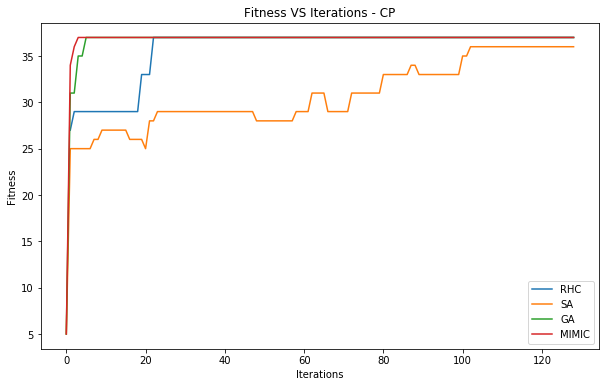

In [17]:

# plot: iter vs fitness
plt.figure(figsize=(10,6))

for alg in algorithm_list:
    df_temp = df_plot[df_plot['Algorithm'] == alg].sort_values(by='Iteration')
    x_coord = df_temp['Iteration'].values
    y_coord = df_temp['Fitness'].values
    plt.plot(x_coord, y_coord, label=alg)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Fitness VS Iterations - {}'.format(problem_name))
plt.show()


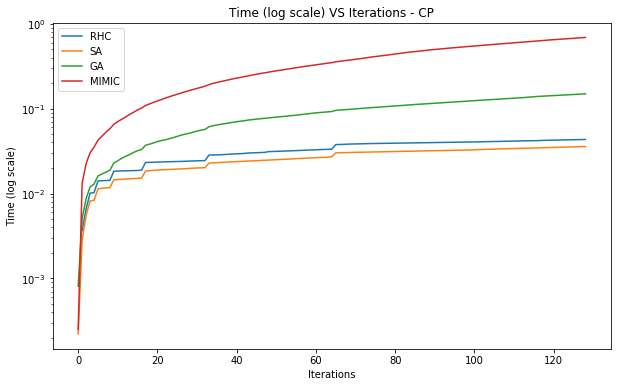

In [18]:

# plot: iter vs time
plt.figure(figsize=(10,6))

for alg in algorithm_list:
    df_temp = df_plot[df_plot['Algorithm'] == alg].sort_values(by='Iteration')
    x_coord = df_temp['Iteration'].values
    y_coord = df_temp['Time'].values
    plt.plot(x_coord, y_coord, label=alg)
plt.legend()
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Time (log scale)')
plt.title('Time (log scale) VS Iterations - {}'.format(problem_name))
plt.show()


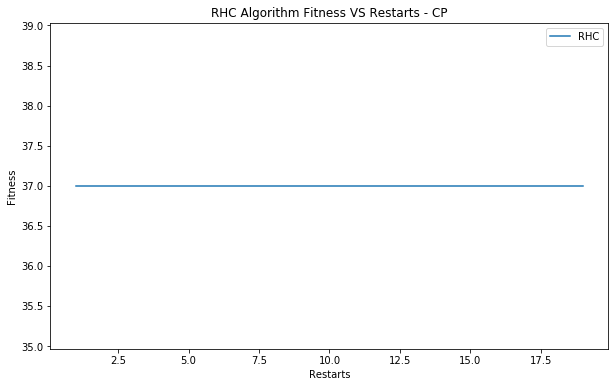

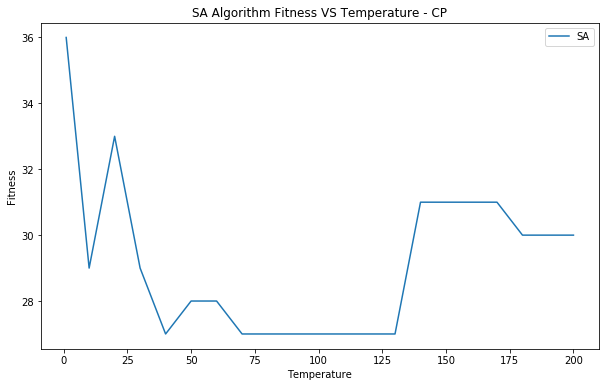

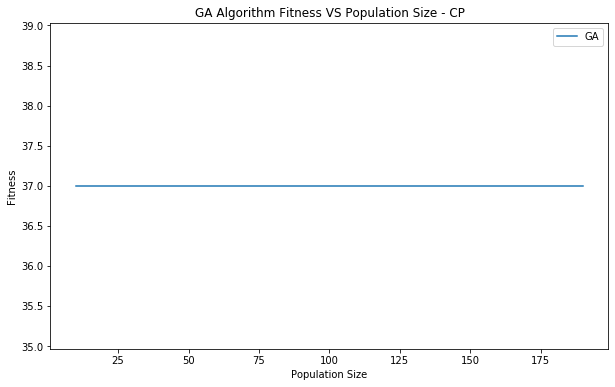

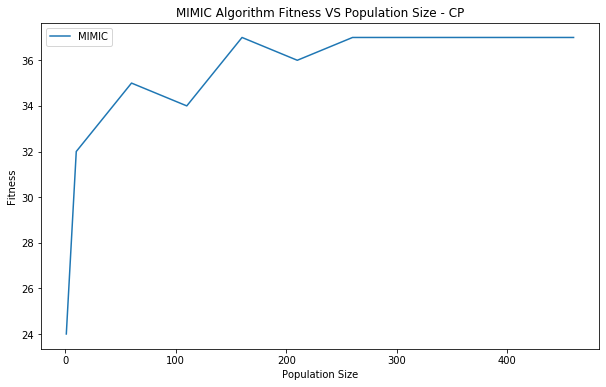

In [19]:
# plot: hyperparam1 vs fitness
param1_dict = {'RHC':'Restarts', 'SA':'Temperature', 'GA':'Population Size', 'MIMIC':'Population Size'}

for alg in param1_dict.keys():
    plt.figure(figsize=(10,6))
    param = param1_dict[alg]
    df_temp = df_p1[df_p1['Algorithm'] == alg].sort_values(by='Param1')
    x_coord = df_temp['Param1'].values
    y_coord = df_temp['Fitness'].values
    plt.plot(x_coord, y_coord, label=alg)
    plt.legend()
    plt.xlabel(param)
    plt.ylabel('Fitness')
    plt.title('{} Algorithm Fitness VS {} - {}'.format(alg, param, problem_name))
    plt.show()



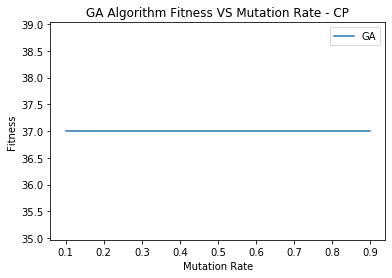

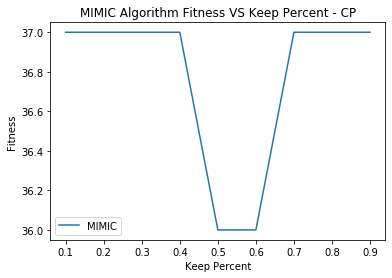

In [20]:
# plot: hyperparam2 vs fitness
param2_dict = {'GA':'Mutation Rate', 'MIMIC':'Keep Percent'}

for alg in param2_dict.keys():
    param = param2_dict[alg]
    df_temp = df_p2[df_p2['Algorithm'] == alg].sort_values(by='Param2')
    x_coord = df_temp['Param2'].values
    y_coord = df_temp['Fitness'].values
    plt.plot(x_coord, y_coord, label=alg)
    plt.legend()
    plt.xlabel(param)
    plt.ylabel('Fitness')
    plt.title('{} Algorithm Fitness VS {} - {}'.format(alg, param, problem_name))
    plt.show()



In [21]:
# extract best performing 
best_param1 = {}
best_param2 = {}
for alg in algorithm_list:
    df_temp = df_p1[df_p1['Algorithm'] == alg]
    param1_name = param1_dict[alg]
    max_idx = df_temp['Param1'].idxmax()
    param1_value = df_temp['Param1'][max_idx]
    best_param1[alg] = {param1_name: param1_value}
    print('best param for {} is when {} is {}'.format(alg, param1_name, param1_value))
    
    if alg in ('GA', 'MIMIC'):
        df_temp = df_p2[df_p2['Algorithm'] == alg]
        param2_name = param2_dict[alg]
        max_idx = df_temp['Param2'].idxmax()
        param2_value = df_temp['Param2'][max_idx]
        best_param2[alg] = {param2_name: param2_value}
        print('best param for {} is when {} is {}'.format(alg, param2_name, param2_value))
    print('\n')


best param for RHC is when Restarts is 19


best param for SA is when Temperature is 200


best param for GA is when Population Size is 190
best param for GA is when Mutation Rate is 0.9


best param for MIMIC is when Population Size is 460
best param for MIMIC is when Keep Percent is 0.9




# Step 2. Stick to the hyperparameter from above, do EDA on various problem sizes.

In [ ]:
# best_param1 = {'RHC': {'Restarts':100}, 'SA': {'Temperature':200}, 'GA': {'Population Size':190},  'MIMIC': {'Population Size':280}}
# best_param2 = {'GA': {'Mutation Rate':0.9},  'MIMIC': {'Keep Percent':0.9}}

In [22]:
columns = ['Algorithm', 'Size', 'Fitness', 'Time']
df_plot3 = pd.DataFrame(columns=columns)

In [23]:

for problem_size in problem_sizes: 
    problem = ContinuousPeaksGenerator().generate(seed=123, size=problem_size)

    # RHC
    param1 = int(best_param1['RHC']['Restarts'])
    rhc = RHCRunner(problem=problem, 
                experiment_name='{}_{}'.format(problem_name, algorithm),
                    output_directory=None, 
                   iteration_list=[2**8],
                    restart_list=[param1],
                    seed=123)
    df_run_stats, df_run_curves = rhc.run()
    fitness, time = df_run_curves.max()[['Fitness', 'Time']]
    df_temp = pd.DataFrame([['RHC', problem_size, fitness, time]], columns=columns)
    df_plot3 = pd.concat([df_plot3, df_temp])
    
    # SA
    param1 = int(best_param1['SA']['Temperature'])
    sa = SARunner(problem=problem, 
                experiment_name='{}_{}'.format(problem_name, algorithm),
                    output_directory=None, 
                   iteration_list=[2**8],
                    temperature_list=[param1],
                    decay_list=[mlrose.ExpDecay],
                    seed=123)
    df_run_stats, df_run_curves = sa.run()
    fitness, time = df_run_curves.max()[['Fitness', 'Time']]
    df_temp = pd.DataFrame([['SA', problem_size, fitness, time]], columns=columns)
    df_plot3 = pd.concat([df_plot3, df_temp])

    # GA
    param1 = int(best_param1['GA']['Population Size'])
    param2 = float(best_param2['GA']['Mutation Rate'])
    ga = GARunner(problem=problem, 
                experiment_name='{}_{}'.format(problem_name, algorithm),
                  output_directory=None, 
                   iteration_list=[2**8],
                  population_sizes=[param1],
                  mutation_rates=[param2],
                  seed=123)

    df_run_stats, df_run_curves = ga.run()
    fitness, time = df_run_curves.max()[['Fitness', 'Time']]
    df_temp = pd.DataFrame([['GA', problem_size, fitness, time]], columns=columns)
    df_plot3 = pd.concat([df_plot3, df_temp])

    
    # MIMIC
    param1 = int(best_param1['MIMIC']['Population Size'])
    param2 = float(best_param2['MIMIC']['Keep Percent'])
    mimic = MIMICRunner(problem=problem, 
                experiment_name='{}_{}'.format(problem_name, algorithm),
                  output_directory=None, 
                   iteration_list=[2**8],
                  population_sizes=[param1],
                  keep_percent_list=[param2],
                  seed=123)
    df_run_stats, df_run_curves = mimic.run()
    fitness, time = df_run_curves.max()[['Fitness', 'Time']]
    df_temp = pd.DataFrame([['MIMIC', problem_size, fitness, time]], columns=columns)
    df_plot3 = pd.concat([df_plot3, df_temp])

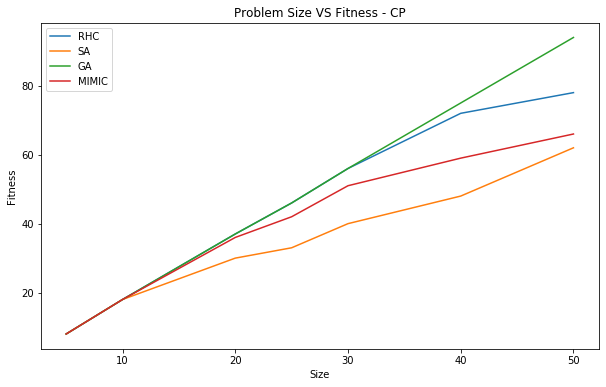

In [24]:
# plot: problem size vs fitness
plt.figure(figsize=(10,6))
for alg in algorithm_list:
    df_temp = df_plot3[df_plot3['Algorithm'] == alg].sort_values(by='Size')
    x_coord = df_temp['Size'].values
    y_coord = df_temp['Fitness'].values
    plt.plot(x_coord, y_coord, label=alg)
plt.legend()
plt.xlabel('Size')
plt.ylabel('Fitness')
plt.title('Problem Size VS Fitness - {}'.format(problem_name))
plt.show()


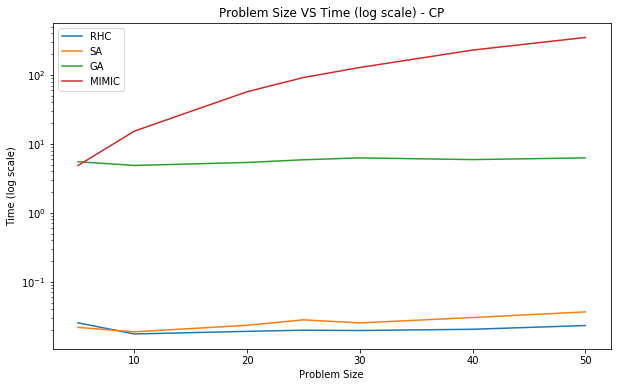

In [25]:
# plot: problem size vs time
plt.figure(figsize=(10,6))
for alg in algorithm_list:
    df_temp = df_plot3[df_plot3['Algorithm'] == alg].sort_values(by='Size')
    x_coord = df_temp['Size'].values
    y_coord = df_temp['Time'].values
    plt.plot(x_coord, y_coord, label=alg)
plt.legend()
plt.xlabel('Problem Size')
plt.ylabel('Time (log scale)')
plt.yscale('log')
plt.title('Problem Size VS Time (log scale) - {}'.format(problem_name))
plt.show()
